In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from helpers import normalize_token, filter_token
import numpy as np
import pandas as pd
import pymc

# Changes in word usage among years

In [4]:
text_root = '../data/SystemsBiology'
documents = nltk.corpus.PlaintextCorpusReader(text_root, '.+.txt')

In [6]:
document_index = pd.DataFrame(columns=['Year', 'File'])
for i, fileid in enumerate(documents.fileids()):
    year = int(fileid[:4]) 
    document_index.loc[i] = [year, fileid]

In [7]:
organism_data = pd.DataFrame(columns=['Year', 'Count'])
i = 0
for year, indices in document_index.groupby('Year').groups.items():
    fileids = document_index.ix[indices].File
    tokens = [normalize_token(token)    # The tokens in this year.
              for token in documents.words(fileids=fileids)
              if filter_token(token)]    
            
    N = len(tokens)    # Number of tokens in this year.
    chunk_size = 200    # This shouldn't be too large.
    for x in xrange(0, N, chunk_size):
        current_chunk = tokens[x:x+chunk_size]    
        count = nltk.FreqDist(current_chunk)['organism']

        # Store the counts for this chunk as an observation.
        organism_data.loc[i] = [year, count]
        i += 1    # Increment the index variable.

In [8]:
# Instead of using values in the 2000s, we'll use the
#  offset from the start. So 2003 is year 0, 2004 is
#  year 1, etc.
X = organism_data.Year - organism_data.Year.min()

# This will create a new rate~Gamma node for each year.
rates = pymc.Container([pymc.Gamma('rate_%i' % year, alpha=1., beta=1.) 
                        for year in organism_data.Year.unique()])

@pymc.deterministic
def rate(r=rates):
    return np.array([rates[int(x)] for x in X])

word_count = pymc.Poisson('word_count', 
                          mu=rate,
                          value=organism_data.Count, 
                          observed=True)
model = pymc.Model({
    'rates': rates,
    'word_count': word_count
})

In [9]:
M2 = pymc.MCMC(model)

In [10]:
M2.sample(iter=20000, burn=1000, thin=10)

 [-----------------100%-----------------] 20000 of 20000 complete in 132.4 sec

Plotting rate_2005
Plotting rate_2009
Plotting rate_2012
Plotting rate_2013
Plotting rate_2010
Plotting rate_2008
Plotting rate_2003
Plotting rate_2011
Plotting rate_2007
Plotting rate_2004
Plotting rate_2006


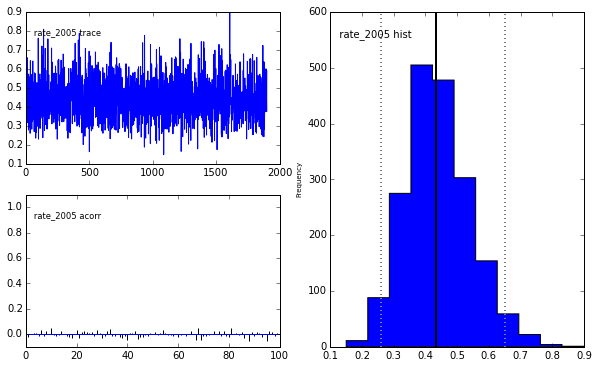

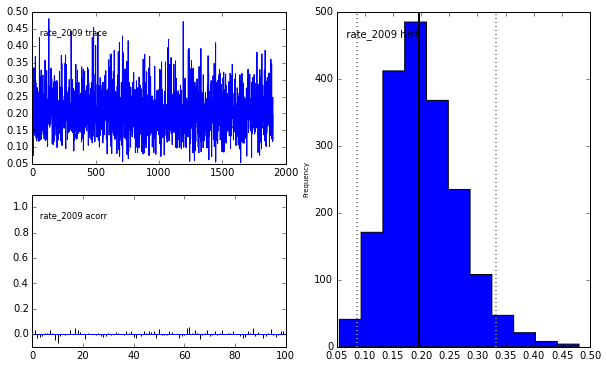

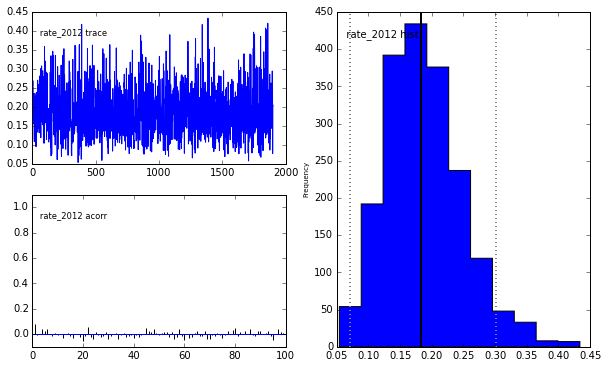

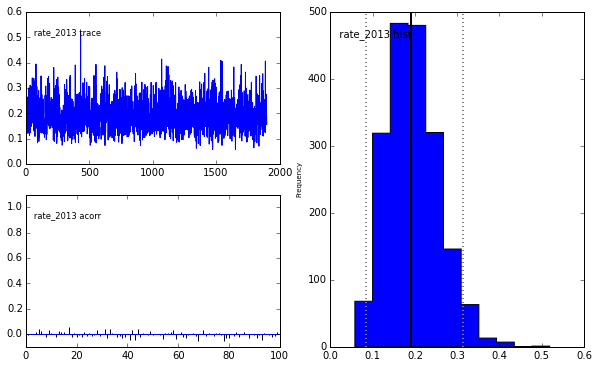

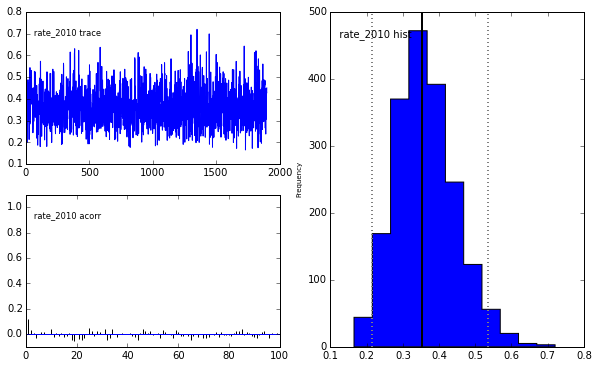

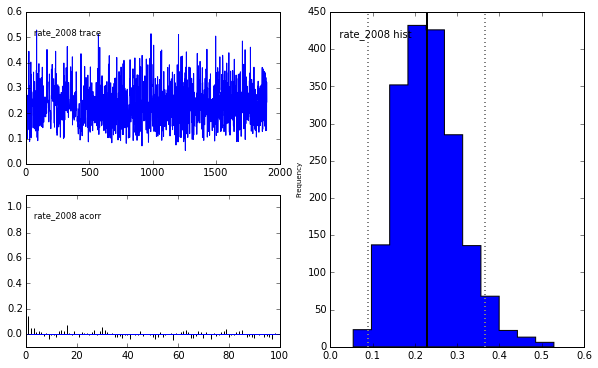

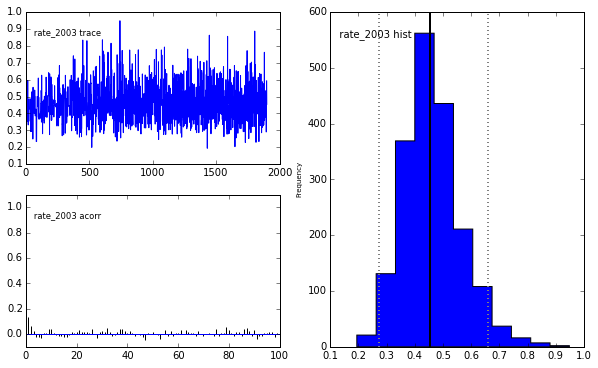

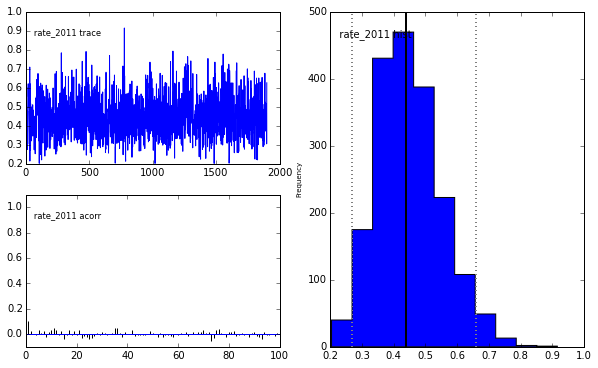

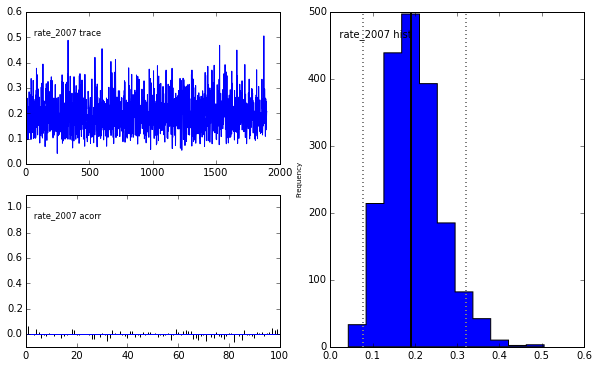

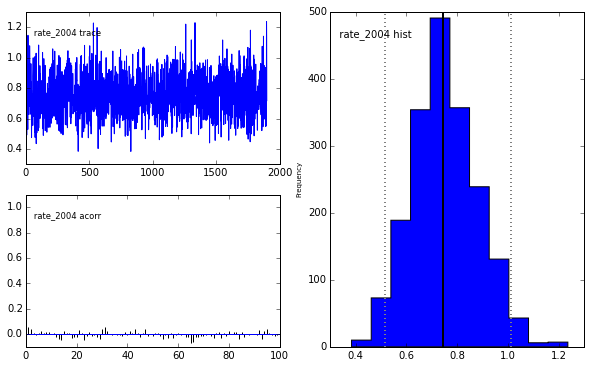

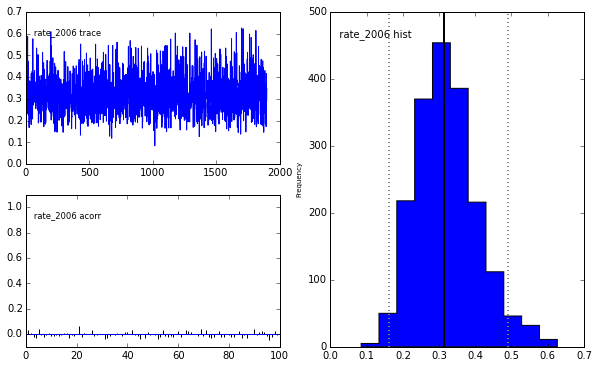

In [11]:
pymc.Matplot.plot(M2)

In [1]:
plt.figure(figsize=(10, 4))
means = organism_data.groupby('Year').mean()

# Plot the means of the observed data in orange.
plt.scatter(means.index, means.Count, 
            color='orange', 
            s=50, 
            label='Mean (rate) from data')

# Plot the means of the samples in blue.
plt.scatter(means.index, [dist.trace()[:].mean() 
                          for dist in M2.rates], 
            label='Mean (rate) from samples')

# Plot the 95% credible interval as box/whiskers.
plt.boxplot([dist.trace()[:] for dist in M2.rates], 
            positions=organism_data.Year.unique(), 
            whis=[2.5, 97.5], 
            showfliers=False)

plt.legend(loc='best')
plt.show()

NameError: name 'plt' is not defined